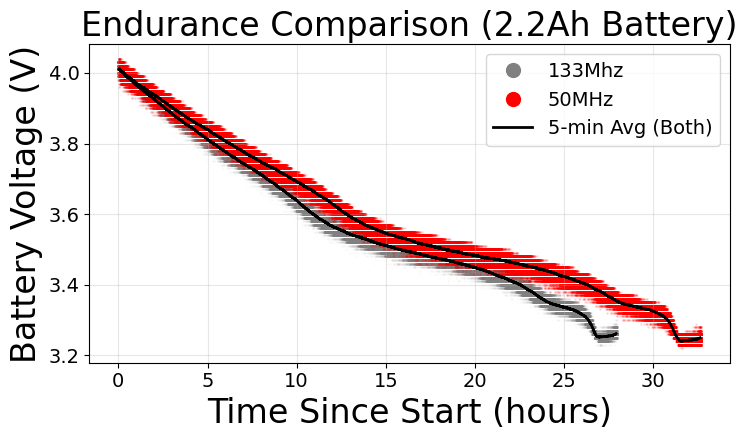

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Load both CSV files ---
normal_file = "2025-07-23T00-29-22_raw.csv"
fifty_file = "2025-07-26T09-35-13.csv"

normal_df = pd.read_csv(normal_file)
fifty_df = pd.read_csv(fifty_file)

# --- Convert time column to datetime ---
normal_df["time"] = pd.to_datetime(normal_df["time"])
fifty_df["time"] = pd.to_datetime(fifty_df["time"])

# --- Normalize time axis (in hours since start) ---
normal_df["hours"] = (normal_df["time"] - normal_df["time"].iloc[0]).dt.total_seconds() / 3600
fifty_df["hours"] = (fifty_df["time"] - fifty_df["time"].iloc[0]).dt.total_seconds() / 3600

# --- Compute 5-minute rolling averages ---
normal_df["vBat_avg"] = normal_df["vBat"].rolling(window=300 * 5, center=True).mean()
fifty_df["vBat_avg"] = fifty_df["vBat"].rolling(window=300 * 5, center=True).mean()

# --- Compute test durations ---
normal_duration = normal_df["hours"].iloc[-1]
fifty_duration = fifty_df["hours"].iloc[-1]

# --- Set up plot ---
fig, ax = plt.subplots(figsize=(7.5, 4.5))

# --- Plot raw data ---
ax.scatter(normal_df["hours"], normal_df["vBat"], color='gray', alpha=0.01, s=1)
ax.scatter(fifty_df["hours"], fifty_df["vBat"], color='red', alpha=0.1, s=1)

# --- Plot black rolling average lines ---
normal_avg_line, = ax.plot(normal_df["hours"], normal_df["vBat_avg"], color='black', linewidth=2,
                           label=f"Normal (5-min Avg)\nDuration: {normal_duration:.2f} hrs")
fifty_avg_line, = ax.plot(fifty_df["hours"], fifty_df["vBat_avg"], color='black', linewidth=2,
                          label=f"50 MHz (5-min Avg)\nDuration: {fifty_duration:.2f} hrs")

# --- Axis labels and grid ---
ax.grid(alpha=0.3)
ax.set_title("Endurance Comparison (2.2Ah Battery)", fontsize=24)
ax.set_xlabel("Time Since Start (hours)", fontsize=24)
ax.set_ylabel("Battery Voltage (V)", fontsize=24)
ax.tick_params(labelsize=14)

# --- Legend ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', alpha=1.0, markersize=6, label="133Mhz"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', alpha=1.0, markersize=6, label="50MHz"),
    Line2D([0], [0], color='black', linewidth=2, label="5-min Avg (Both)")
]
ax.legend(handles=legend_elements, fontsize=14, loc="upper right", markerscale=2)

plt.tight_layout()
plt.savefig("testEndurance_battV.jpg", dpi=600)

In [2]:
import pandas as pd
import os

# Define file paths
normal_file = "2025-07-23T00-29-22_raw.csv"
fifty_file = "2025-07-26T09-35-13.csv"

# Load both CSVs
normal_df = pd.read_csv(normal_file)
fifty_df = pd.read_csv(fifty_file)

# Convert time columns to datetime
normal_df["time"] = pd.to_datetime(normal_df["time"])
fifty_df["time"] = pd.to_datetime(fifty_df["time"])

# Function to analyze each file
def analyze_logging(df, label, file_path):
    # Sampling frequency
    time_deltas = df["time"].diff().dt.total_seconds().dropna()
    avg_interval = time_deltas.mean()
    hz = 1 / avg_interval if avg_interval > 0 else float('nan')
    
    # Duration
    duration_sec = (df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds()
    duration_min = duration_sec / 60
    duration_hr = duration_min / 60
    
    # File size (bytes)
    file_size_bytes = os.path.getsize(file_path)
    bytes_per_sec = file_size_bytes / duration_sec if duration_sec > 0 else float('nan')
    
    # SD card fill estimate
    sd_card_size = 256 * 1024 * 1024  # 256 MB
    time_to_fill_sec = sd_card_size / bytes_per_sec
    time_to_fill_hr = time_to_fill_sec / 3600
    time_to_fill_day = time_to_fill_hr / 24

    # Print results
    print(f"--- {label} ---")
    print(f"Sampling frequency: {hz:.2f} Hz")
    print(f"Total duration: {duration_min:.2f} min ({duration_hr:.2f} hr)")
    print(f"File size: {file_size_bytes/1024:.1f} KB")
    print(f"Logging rate: {bytes_per_sec:.2f} bytes/sec")
    print(f"Estimated time to fill 256MB SD card: {time_to_fill_hr:.2f} hr ({time_to_fill_day:.2f} days)")
    print()

# Run for both files
analyze_logging(normal_df, "Normal (default clock)", normal_file)
analyze_logging(fifty_df, "50 MHz", fifty_file)


--- Normal (default clock) ---
Sampling frequency: 5.02 Hz
Total duration: 1677.87 min (27.96 hr)
File size: 37017.7 KB
Logging rate: 376.53 bytes/sec
Estimated time to fill 256MB SD card: 198.03 hr (8.25 days)

--- 50 MHz ---
Sampling frequency: 4.69 Hz
Total duration: 1960.68 min (32.68 hr)
File size: 40416.2 KB
Logging rate: 351.80 bytes/sec
Estimated time to fill 256MB SD card: 211.95 hr (8.83 days)



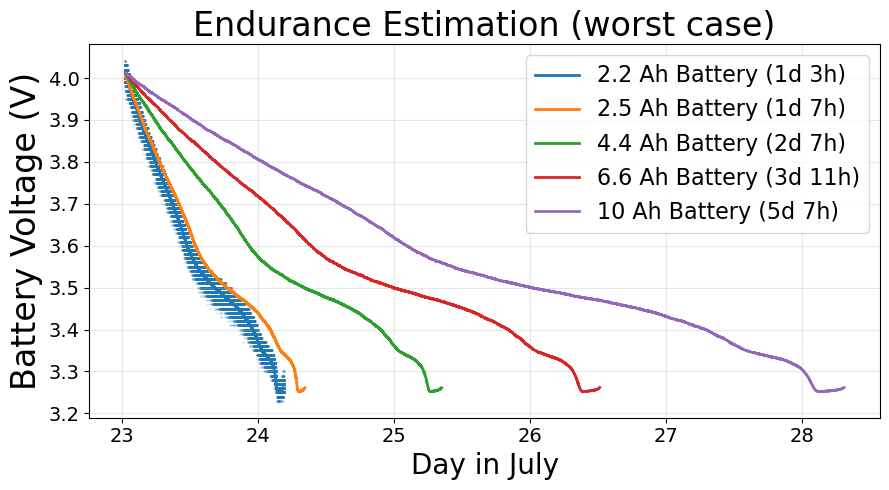

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import numpy as np

# Load CSV file (2.2Ah battery data)
fname = "2025-07-23T00-29-22_raw.csv"
df = pd.read_csv(fname)
df["time"] = pd.to_datetime(df["time"])

# Calculate total duration in seconds for 2.2Ah battery
duration_2_2 = (df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds()

# Battery capacities in Ah
battery_caps = [2.2, 2.5, 4.4, 6.6, 10]

# Compute rolling average (5-min window at 5Hz = 1500 samples)
df["vBat_avg"] = df["vBat"].rolling(window=300 * 5, center=True).mean()

# Helper function to format seconds into "Xd Yh" (no minutes)
def format_duration(seconds):
    days = int(seconds // 86400)
    hours = int((seconds % 86400) // 3600)
    parts = []
    if days > 0:
        parts.append(f"{days}d")
    parts.append(f"{hours}h")
    return " ".join(parts)

# Create figure and axis
fig, ax = plt.subplots(figsize=(9, 5))

# Configure x-axis locator and formatter
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.get_offset_text().set_visible(False)  # hide offset date label

# Plotting colors and labels
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(battery_caps)]

for cap, color in zip(battery_caps, colors):
    scale_factor = cap / 2.2
    scaled_duration_sec = duration_2_2 * scale_factor
    duration_str = format_duration(scaled_duration_sec)
    time_start = df["time"].iloc[0]
    scaled_seconds = (df["time"] - time_start).dt.total_seconds() * scale_factor
    scaled_time = time_start + pd.to_timedelta(scaled_seconds, unit='s')

    if cap == 2.2:
        # Plot raw voltage scatter for original data only
        ax.scatter(scaled_time, df["vBat"], color=color, alpha=0.1, s=1, label=None)
    
    # Plot rolling average line for all batteries
    ax.plot(scaled_time, df["vBat_avg"], color=color, linewidth=2,
            label=f"{cap} Ah Battery ({duration_str})")

# Formatting
ax.grid(alpha=0.3)
ax.set_title("Endurance Estimation (worst case)", fontsize=24)
ax.set_xlabel("Day in July", fontsize=20)
ax.set_ylabel("Battery Voltage (V)", fontsize=24)
ax.tick_params(labelsize=14)

# Legend (larger markerscale for visibility)
ax.legend(fontsize=16, markerscale=5, loc="best")
 
plt.tight_layout()
plt.savefig("testEndurance_battV_estimation.jpg", dpi=600)  # save to file

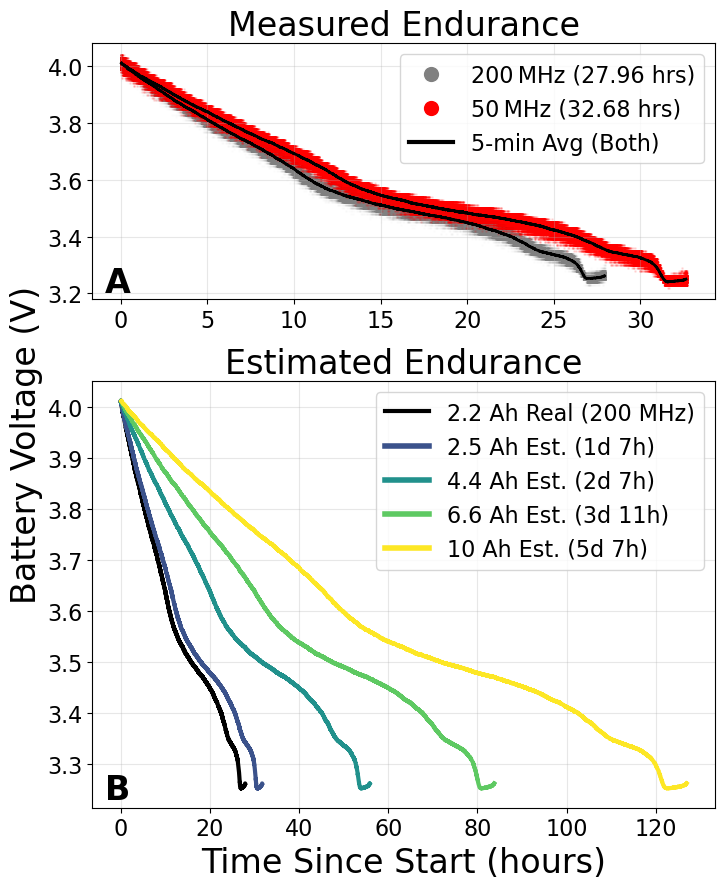

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# File paths
normal_file = "2025-07-23T00-29-22_raw.csv"
fifty_file = "2025-07-26T09-35-13.csv"

# Load both
normal_df = pd.read_csv(normal_file)
fifty_df = pd.read_csv(fifty_file)

# Convert to datetime
normal_df["time"] = pd.to_datetime(normal_df["time"])
fifty_df["time"] = pd.to_datetime(fifty_df["time"])

# Normalize to hours since start
normal_df["hours"] = (normal_df["time"] - normal_df["time"].iloc[0]).dt.total_seconds() / 3600
fifty_df["hours"] = (fifty_df["time"] - fifty_df["time"].iloc[0]).dt.total_seconds() / 3600

# Compute test durations in hours
duration_normal_hr = normal_df["hours"].iloc[-1]
duration_fifty_hr = fifty_df["hours"].iloc[-1]

# Rolling average
normal_df["vBat_avg"] = normal_df["vBat"].rolling(window=300*5, center=True).mean()
fifty_df["vBat_avg"] = fifty_df["vBat"].rolling(window=300*5, center=True).mean()

# Use normal_df as base for projections
df = normal_df.copy()
duration_2_2 = (df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds()
duration_hours = duration_2_2 / 3600

# --- Create figure with shared x-axis ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 9), sharex=False, gridspec_kw={'height_ratios': [3, 5]})
fig.text(0.04, 0.5, 'Battery Voltage (V)', va='center', rotation='vertical', fontsize=24)
ax2.set_xlabel("Time Since Start (hours)", fontsize=24)

# --- TOP PLOT: Measured runs ---
ax1.scatter(normal_df["hours"], normal_df["vBat"], color='gray', alpha=0.01, s=1)
ax1.scatter(fifty_df["hours"], fifty_df["vBat"], color='red', alpha=0.1, s=1)
ax1.plot(normal_df["hours"], normal_df["vBat_avg"], color='black', linewidth=2)
ax1.plot(fifty_df["hours"], fifty_df["vBat_avg"], color='black', linewidth=2)
ax1.grid(alpha=0.3)
ax1.set_title("Measured Endurance", fontsize=24)
ax1.tick_params(labelsize=16)
ax1.text(0.02, 0.03, "A", transform=ax1.transAxes, fontsize=24, fontweight='bold')

# --- LEGEND BLOCK SUBPLOT A ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', alpha=1.0, markersize=12,
           label=f"200 MHz ({duration_normal_hr:.2f} hrs)"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', alpha=1.0, markersize=12,
           label=f"50 MHz ({duration_fifty_hr:.2f} hrs)"),
    Line2D([0], [0], color='black', linewidth=3, label="5-min Avg (Both)")
]
ax1.legend(handles=legend_elements, fontsize=16, loc="best")

ax1.legend(handles=legend_elements, fontsize=16, loc="best")

# --- BOTTOM PLOT: Real + estimated projections ---
battery_caps = [2.2, 2.5, 4.4, 6.6, 10]
colors = plt.cm.viridis(np.linspace(0, 1, len(battery_caps)))

def format_duration(seconds):
    days = int(seconds // 86400)
    hours = int((seconds % 86400) // 3600)
    parts = []
    if days > 0: parts.append(f"{days}d")
    parts.append(f"{hours}h")
    return " ".join(parts)

base_seconds = (df["time"] - df["time"].iloc[0]).dt.total_seconds()
base_hours = base_seconds / 3600

for cap, color in zip(battery_caps, colors):
    scale_factor = cap / 2.2
    scaled_hours = base_hours * scale_factor
    duration_str = format_duration(duration_2_2 * scale_factor)
    
    if cap == 2.2:
        # Real data only for 2.2Ah
        # ax2.scatter(df["hours"], df["vBat"], color='gray', alpha=0.01, s=1, label="133 MHz")
        ax2.plot(df["hours"], df["vBat_avg"], color='black', linewidth=3, label=f"2.2 Ah Real (133MHz) ({duration_str})")
    else:
        ax2.plot(scaled_hours, df["vBat_avg"], color=color, linewidth=3, label=f"{cap} Ah Est. ({duration_str})")

ax2.grid(alpha=0.3)
ax2.set_title("Estimated Endurance", fontsize=24)
ax2.tick_params(labelsize=16)
ax2.text(0.02, 0.02, "B", transform=ax2.transAxes, fontsize=24, fontweight='bold')

legend_elements_b = [
    # Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', alpha=0.3, markersize=8, label="133 MHz"),
    Line2D([0], [0], color='black', linewidth=3, label="2.2 Ah Real (200 MHz)"),
]

# Custom lines for each estimated battery capacity
for cap, color in zip(battery_caps[1:], colors[1:]):  # skip 2.2Ah (already handled)
    duration_str = format_duration(duration_2_2 * (cap / 2.2))
    legend_elements_b.append(Line2D([], [], color=color, linewidth=4,
                                    label=f"{cap} Ah Est. ({duration_str})"))

ax2.legend(handles=legend_elements_b, fontsize=16, loc="best")

# Final formatting
ax1.set_ylabel('')
ax2.set_ylabel('')
plt.tight_layout(rect=[0.07, 0, 1, 1])
plt.savefig("testEndurance_battV_real_and_estimate.jpg", dpi=600)